# API - Quickstart

This is a quickstart guide to using the API. For more detailed information, see the 
[API Documentation](apidoc/glassure.core.rst).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


## Loading a sample pattern and the background

The basic class for handling x-y data in Glassure is the `Pattern` class. It can be used to load data from a file
or to create a pattern from scratch.

In [2]:
from glassure import Pattern
from tests import data_path
pattern = Pattern.from_file(data_path('Mg2SiO4_ambient.xy'))
bkg = Pattern.from_file(data_path('Mg2SiO4_ambient_bkg.xy'))

## Plotting the data
The `Pattern` objects can be easily plotted using matplotlib:

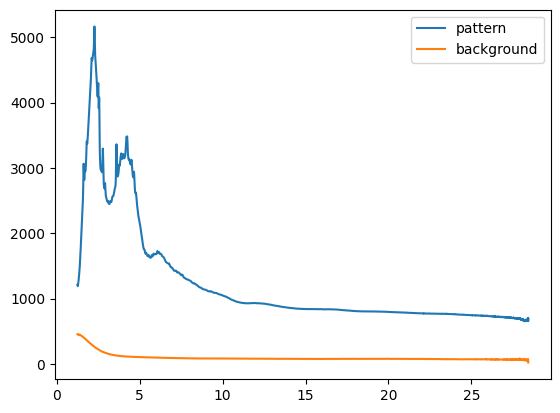

In [3]:
plt.figure()
plt.plot(pattern.x, pattern.y, label='pattern')
plt.plot(bkg.x, bkg.y, label='background')
plt.legend();

## Subtracting the background

`Pattern` objects can be subtracted from each other. The result is a new `Pattern` object. Here we use this to 
subtract the background from the pattern. Before we scale the background pattern differently.

In [4]:
bkg.scaling = 1.1
sample = pattern - bkg

## Calculating the Structure Factor $S(Q)$

The Faber Ziman structure factor can now be calculated. For this we need the composition, which will be given as a dictionary, and a density estimate of the sample:

In [5]:
from glassure.utility import convert_density_to_atoms_per_cubic_angstrom

composition = {'Mg': 2, 'Si': 1, 'O': 4}
density = 2.7 # g/cm^3
atomic_density = convert_density_to_atoms_per_cubic_angstrom(composition, density) # atoms/A^3

The most important part for calculating S(Q) is the normalization of the collected intensity to atomic units. We will utilize a fit method here. With this method the normalization factor is estimated by a match of the sample pattern with the sum of the squared mean form factors of the sample and the incoherent scattering.

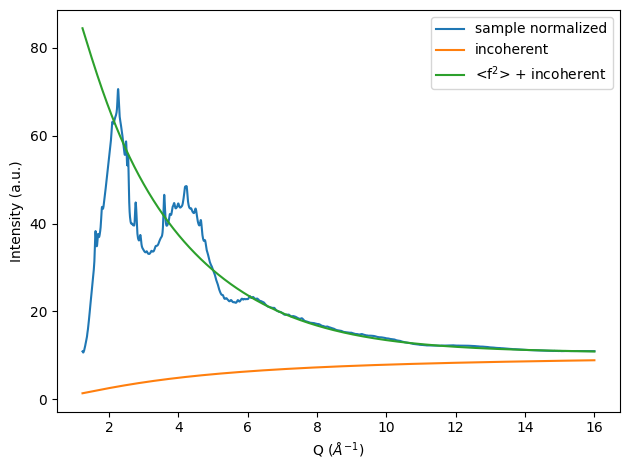

In [6]:
from glassure.utility import calculate_f_squared_mean, calculate_incoherent_scattering
from glassure.normalization import normalize_fit


sample = sample.limit(0, 16)

f_squared_mean = calculate_f_squared_mean(composition, sample.x)
incoherent_scattering = calculate_incoherent_scattering(composition, sample.x)
params, normalized_pattern = normalize_fit(sample, f_squared_mean, incoherent_scattering, q_cutoff=5)

n = params['n'].value

plt.figure()
plt.plot(sample.x, n * sample.y, label='sample normalized')
plt.plot(sample.x, incoherent_scattering, label='incoherent')
plt.plot(sample.x, f_squared_mean + incoherent_scattering, label='<f$^2$> + incoherent')
plt.xlabel('Q ($\\AA^{-1}$)'); plt.ylabel('Intensity (a.u.)')
plt.legend(); plt.tight_layout();

With the normalized pattern and incoherent subtracted pattern available we can now calculate the Structure factor: 

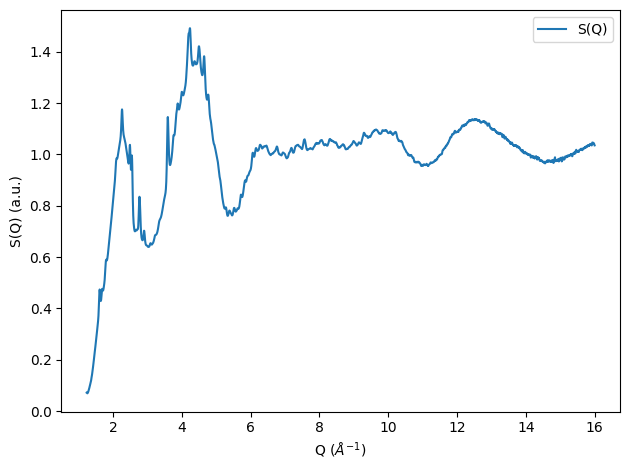

In [7]:
from glassure.transform import calculate_sq
from glassure.utility import calculate_f_mean_squared
f_mean_squared = calculate_f_mean_squared(composition, sample.x)

sq = calculate_sq(normalized_pattern, f_squared_mean, f_mean_squared)

plt.figure()
plt.plot(sq.x, sq.y, label='S(Q)')
plt.xlabel('Q ($\\AA^{-1}$)'); plt.ylabel('S(Q) (a.u.)')
plt.legend(); plt.tight_layout();

## Calculating the pair distribution function $g(r)$

The main function for calculating the transforms are inside the `glassure.core.transform` module. The `calculate_fr` function calculates the Fourier transform of the structure factor and the `calculate_gr` function calculates the pair distribution function from the Fourier transform.

In [8]:
from  glassure.transform import calculate_fr, calculate_gr
fr = calculate_fr(sq)
gr = calculate_gr(fr, atomic_density)

## Plotting the results

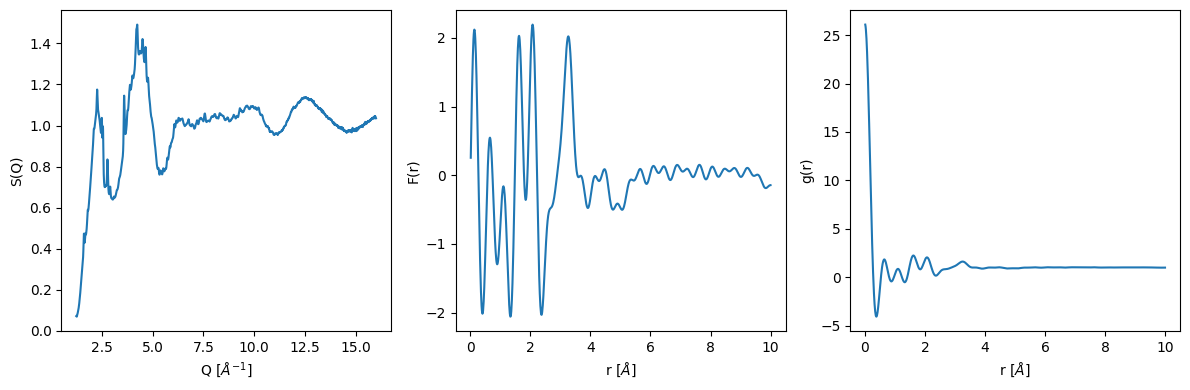

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(sq.x, sq.y)
plt.xlabel('Q [$\\AA^{-1}$]')
plt.ylabel('S(Q)')
plt.subplot(132)
plt.plot(fr.x, fr.y)
plt.xlabel('r [$\\AA$]')
plt.ylabel('F(r)')
plt.subplot(133)
plt.plot(gr.x, gr.y)
plt.xlabel('r [$\\AA$]')
plt.ylabel('g(r)')
plt.tight_layout()


## Refining the calculations

While the above calculations are already quite good, we can improve them by refining several steps. 

### Optimizing the Structure Factor S(Q) 
As with all total scattering experiments, it is very difficult to account for all effects on the intensity of the collected signal (However, if please perform all possible corrections before to the data, e.g. Multiple Scattering or Fluorescence). 

Several ways have been proposed in the past to improve the results:

- the background can be refined using a polynomial fit - this is done by PDFGetX3 by default - but works poorly for amorphous materials and liquids
- removing unphysical oscillations in the low r region of the g(r), by back transforming this area into S(Q), this has been described by [Kaplow et al., 1965](https://doi.org/10.1103/PhysRev.138.A1336), performing this multiple times results in a more physical result - this is the default method chosen for glassure - typically the iterations number should be between 3 and 5, if more are necessary, other factors should be considered

### Extending the Q-range to zero
It is often difficult to obtain diffraction at very large Q as well as in the low-Q region. However, the Fourier transform is affected by a limited Q-range, and for reasonable results the pattern should be extended to q = 0. The theoretical value for a monatomic liquid S(Q=0) is:

\begin{equation}
S(Q=0) = \rho \chi_T k_B T
\end{equation}

where $\rho$ is the density, $\chi_T$ is the isothermal compressibility and $k_B$ is the Boltzmann constant and $T$ is the temperature. Since most materials have a very low compressibility, this is very close to zero.
 
For polyatomic materials, the value can become negative and is mainly influenced by the differences of elemental form factors at q=0. It can be estimated using the following equation:

\begin{equation}
S(Q) = \frac{I(Q)-\sum_{\alpha}c_{\alpha}f_{\alpha}^2(Q) - C(Q)}{\left[\sum_{\alpha}c_{\alpha}f_{\alpha}(Q)]\right]^2} + 1
\end{equation}

where $I(Q)$ is the measured intensity, $f_{\alpha}(Q)$ is the scattering factor of the $\alpha$-th element, $c_{\alpha}$ is the concentration of the $\alpha$-th element and $C(Q)$ is the Compton intensity. The value of $S(Q=0)$ is then calculated by extrapolating the $S(Q)$ to $Q=0$ where I(Q) and C(Q) approach zero.

### Using a filter function to remove Fourier transform artifacts
The Fourier transformation from S(Q) to F(r) will always result in some artifacts, due to the limited Q-range of the S(Q) data. To suppress these artifacts we can employ a filter function during the transformation such as the Lorch-Modification function ([Lorch, 1969](https://doi.org/10.1088/0022-3719/2/2/305))


In [ ]:
from glassure.optimization import optimize_sq
from glassure.utility import calculate_s0

# we need to extend the sq to q=0, for simplicity we use a step function, but
# other more potent methods are available in the utility module
sq = sq.extend_to(0, calculate_s0(composition))
sq_opt = optimize_sq(sq, 
                     r_cutoff=1.4, 
                     iterations=5,
                     atomic_density=atomic_density)
fr_opt = calculate_fr(sq_opt)
gr_opt = calculate_gr(fr_opt, atomic_density)

fr_opt_lorch = calculate_fr(sq_opt, use_modification_fcn=True)
gr_opt_lorch = calculate_gr(fr_opt_lorch, atomic_density)

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(sq.x, sq.y, label='original')
plt.plot(sq_opt.x, sq_opt.y, label='optimized')
plt.xlabel('Q [$\\AA^{-1}$]')
plt.ylabel('S(Q)')
plt.legend()
plt.subplot(132)
plt.plot(fr.x, fr.y, label='original')
plt.plot(fr_opt.x, fr_opt.y, label='optimized')
plt.plot(fr_opt_lorch.x, fr_opt_lorch.y, label='optimized + Lorch')
plt.xlabel('r [$\\AA$]')
plt.ylabel('F(r)')
plt.legend()
plt.subplot(133)
plt.plot(gr.x, gr.y, label='original')
plt.plot(gr_opt.x, gr_opt.y, label='optimized')
plt.plot(gr_opt_lorch.x, gr_opt_lorch.y, label='optimized + Lorch')
plt.ylim(-1, 3)
plt.xlabel('r [$\\AA$]')
plt.ylabel('g(r)')
plt.legend()
plt.tight_layout();

It can be clearly seen that the Kaplow-Optimization successfully removes the unphysical oscillations in the low r region. However, the r_cutoff for the back and forward transformation has to be chosen carefully. Furthermore, it is of large importance that the optimization procedure does not completely distort the original structure factor. If the optimized structure factor and the original unoptimized structure differ a lot, please consider other corrections to the data before proceeding with the PDF Analysis. This optimization procedure should only be used as a final step. 

The Lorch-modification function further smooths the g(r) and removes the artifacts from the Fourier transformation. However, it also removes information from the g(r) (loss of resolution). 


## Conclusion

This notebook showed how to use the Glassure API to calculate the structure factor and the pair distribution function from collected total scattering XRD data. It also showed how to optimize the S(Q). For more information on the possibilities in the Glassure API, please see the [API Documentation](apidoc/glassure.core.rst).